### Change log

#### 1. Observe the feat distribution via t-SNE 
#### 2. Re-sampling the unbalanced data to balance via over-sampling and SMOTE
#### 3. Replace the previous R0 (3 categories) with the numerical R0 value.
* Change the negative value to the mean of the other positive values

#### 4. Train/evaluate the models using the unbalanced and balanced data.
#### 5. Adjus the monitor metrics from f1_weight to original loss
* TBD: Select the most suitable evaluation metrics as the cross-validation monitor_metrics

#### 6 Compare the softmax output (ie the probability of each dynamic sums to one) vs the independent probability (the probability of a dynamic is independent from the other and doesn’t sum up to one, it can be even 1 for all).
#### 7. Save the models and analyze the mis-classification of the growing clusters, ie which are wrongly assigned to stable or decaying.
* Visualize via the confusion matrix

#### 8. Analysis the classification result via the HiPlot
#### 9. Convert the codes to the module format

### Load the train/test

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../data/" directory

import os
import os.path as osp
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2
%matplotlib inline

ds_name = '04272021'
split_rs = '123'
ds_folder = f'../data/{ds_name}/correct_trees_split_rs{split_rs}'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/04272021/correct_trees_split_rs123/test.csv
../data/04272021/correct_trees_split_rs123/train.csv
../data/04272021/correct_trees_split_rs123/test_edge.csv
../data/04272021/correct_trees_split_rs123/train_edge.csv


In [2]:
#Import the files
train_df = pd.read_csv(f'{ds_folder}/train.csv')
test_df = pd.read_csv(f'{ds_folder}/test.csv')

In [3]:
test_df.tail()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm
510462,Background,987,Background,static,0.0,0.050815,555,81.0,-17.763255,81.004321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
510463,Background,987,Background,static,0.0,0.050815,555,81.0,-17.763255,81.004321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
510464,Background,987,Background,static,0.0,0.050815,555,81.0,-17.763255,81.004321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
510465,Background,987,Background,static,0.0,0.050815,555,81.0,-17.763255,81.004321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
510466,Background,987,Background,static,0.0,0.050815,555,81.0,-17.763255,81.004321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Remove the background nodes

In [4]:
train_df = train_df[train_df['cluster_id'] != 'Background']
test_df = test_df[test_df['cluster_id'] != 'Background']
print(f'Train: {train_df.shape}\nTest: {test_df.shape}')

Train: (278286, 48)
Test: (71829, 48)


In [5]:
test_df.tail()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm
71824,c7,987,F,growth,0.031741,0.390442,16,15.0,-0.796687,15.026066,...,-0.76702,-0.584765,-0.585766,-0.024907,-0.705023,-0.012074,-1.219814,0.014845,0.338662,0.394747
71825,c7,987,F,growth,0.031741,0.390442,16,15.0,-0.796687,15.026066,...,-0.76702,-0.584765,-0.585766,-0.024907,-0.705023,-0.012074,-1.219814,0.014845,0.338662,0.394747
71826,c7,987,F,growth,0.031741,0.390442,16,15.0,-0.796687,15.026066,...,-0.76702,-0.584765,-0.585766,-0.024907,-0.705023,-0.012074,-1.219814,0.014845,0.338662,0.394747
71827,c7,987,F,growth,0.031741,0.390442,16,15.0,-0.796687,15.026066,...,-0.76702,-0.584765,-0.585766,-0.024907,-0.705023,-0.012074,-1.219814,0.014845,0.338662,0.394747
71828,c7,987,F,growth,0.031741,0.390442,16,15.0,-0.796687,15.026066,...,-0.76702,-0.584765,-0.585766,-0.024907,-0.705023,-0.012074,-1.219814,0.014845,0.338662,0.394747


### Load the feature desciption

In [6]:
import json
js_f = osp.join('../aly/feat_dict0427.json')

with open(js_f, 'r') as f:
    feat_desc = json.load(f)

input_feat = feat_desc['norm_onehot_feats']
print(f'Inputs: {len(input_feat)}, {input_feat}')
label_feat = 'dynamic_cat'

label_map = feat_desc['dynamic']
label_map = {int(k): v for k, v in label_map.items()}
print(label_map)

Inputs: 22, ['v_sampling_fraction-norm', 'v_cluster_size-norm', 'v_timespan-norm', 'oster-norm', 'birth_rate-norm', 'PD-norm', 'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'BLD-norm', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'R0_cat_0', 'R0_cat_1', 'R0_cat_2', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3']
{0: 'decay', 1: 'growth', 2: 'static'}


#### Replace the previous R0 (3 categories) with the normalized numerical R0 value.

In [7]:
rm_r0_cols = set(['R0_cat_0', 'R0_cat_1', 'R0_cat_2'])
input_feat = [feat for feat in input_feat if feat not in rm_r0_cols]
print(len(input_feat), input_feat)

19 ['v_sampling_fraction-norm', 'v_cluster_size-norm', 'v_timespan-norm', 'oster-norm', 'birth_rate-norm', 'PD-norm', 'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'BLD-norm', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3']


#### Remove the negative R0 and normalize it
* Use the mean value of positive R0 in the **training** to replace all the negative R0 in the training and test
* Normalize the R0 

In [8]:
from sklearn import preprocessing

train_raw_r0 = np.reshape(train_df['R0'].values, (-1, 1))
test_raw_r0 = np.reshape(test_df['R0'].values, (-1, 1))

# negtive replacement for train
train_r0_neg_idx = train_raw_r0 <= 0
train_r0_pos_idx = train_raw_r0 > 0
avg_train_r0 = np.average(train_raw_r0[train_r0_pos_idx])

train_raw_r0[train_r0_neg_idx] = avg_train_r0

# neg replacement for test
test_r0_neg_idx = test_raw_r0 <= 0
test_raw_r0[test_r0_neg_idx] = avg_train_r0

In [9]:
train_df['R0'].describe()

count    278286.000000
mean          1.874134
std           0.839096
min           0.000714
25%           1.704934
50%           1.874134
75%           1.874134
max           8.031219
Name: R0, dtype: float64

In [10]:
# Standardization non-category features
r0_norm_col = 'R0-norm'
std_scaler = preprocessing.StandardScaler().fit(train_raw_r0)
norm_train_vals = std_scaler.transform(train_raw_r0)

norm_train_node_df = pd.DataFrame(norm_train_vals, columns=[r0_norm_col], index=train_df.index)
train_df = pd.concat([train_df, norm_train_node_df], axis=1)

train_df[r0_norm_col].describe()

count    2.782860e+05
mean    -2.091649e-16
std      1.000002e+00
min     -2.232667e+00
25%     -2.016453e-01
50%      0.000000e+00
75%      0.000000e+00
max      7.337772e+00
Name: R0-norm, dtype: float64

In [11]:
norm_test_vals = std_scaler.transform(test_raw_r0)
norm_test_df = pd.DataFrame(norm_test_vals, columns=[r0_norm_col], index=test_df.index)
test_df = pd.concat([test_df, norm_test_df], axis=1)

test_df[r0_norm_col].describe()

count    71829.000000
mean         0.023268
std          0.998039
min         -2.212820
25%         -0.230298
50%          0.000000
75%          0.008908
max          6.893695
Name: R0-norm, dtype: float64

In [12]:
input_feat += [r0_norm_col]
input_feat

['v_sampling_fraction-norm',
 'v_cluster_size-norm',
 'v_timespan-norm',
 'oster-norm',
 'birth_rate-norm',
 'PD-norm',
 'abs_growth_rate-norm',
 'fraction_time_growth-norm',
 'r_max-norm',
 'cherries-norm',
 'BLD-norm',
 'ltt_shape_cat_0',
 'ltt_shape_cat_1',
 'ltt_shape_cat_2',
 'ltt_shape_cat_3',
 'gamma_cat_0',
 'gamma_cat_1',
 'gamma_cat_2',
 'gamma_cat_3',
 'R0-norm']

In [13]:
x_train = train_df[input_feat]
y_train = train_df[label_feat]
treeid_train = train_df['sim']

x_test = test_df[input_feat]
y_test = test_df[label_feat]
treeid_test = test_df['sim']

array([[<AxesSubplot:title={'center':'v_sampling_fraction-norm'}>,
        <AxesSubplot:title={'center':'v_cluster_size-norm'}>,
        <AxesSubplot:title={'center':'v_timespan-norm'}>,
        <AxesSubplot:title={'center':'oster-norm'}>],
       [<AxesSubplot:title={'center':'birth_rate-norm'}>,
        <AxesSubplot:title={'center':'PD-norm'}>,
        <AxesSubplot:title={'center':'abs_growth_rate-norm'}>,
        <AxesSubplot:title={'center':'fraction_time_growth-norm'}>],
       [<AxesSubplot:title={'center':'r_max-norm'}>,
        <AxesSubplot:title={'center':'cherries-norm'}>,
        <AxesSubplot:title={'center':'BLD-norm'}>,
        <AxesSubplot:title={'center':'ltt_shape_cat_0'}>],
       [<AxesSubplot:title={'center':'ltt_shape_cat_1'}>,
        <AxesSubplot:title={'center':'ltt_shape_cat_2'}>,
        <AxesSubplot:title={'center':'ltt_shape_cat_3'}>,
        <AxesSubplot:title={'center':'gamma_cat_0'}>],
       [<AxesSubplot:title={'center':'gamma_cat_1'}>,
        <AxesSubp

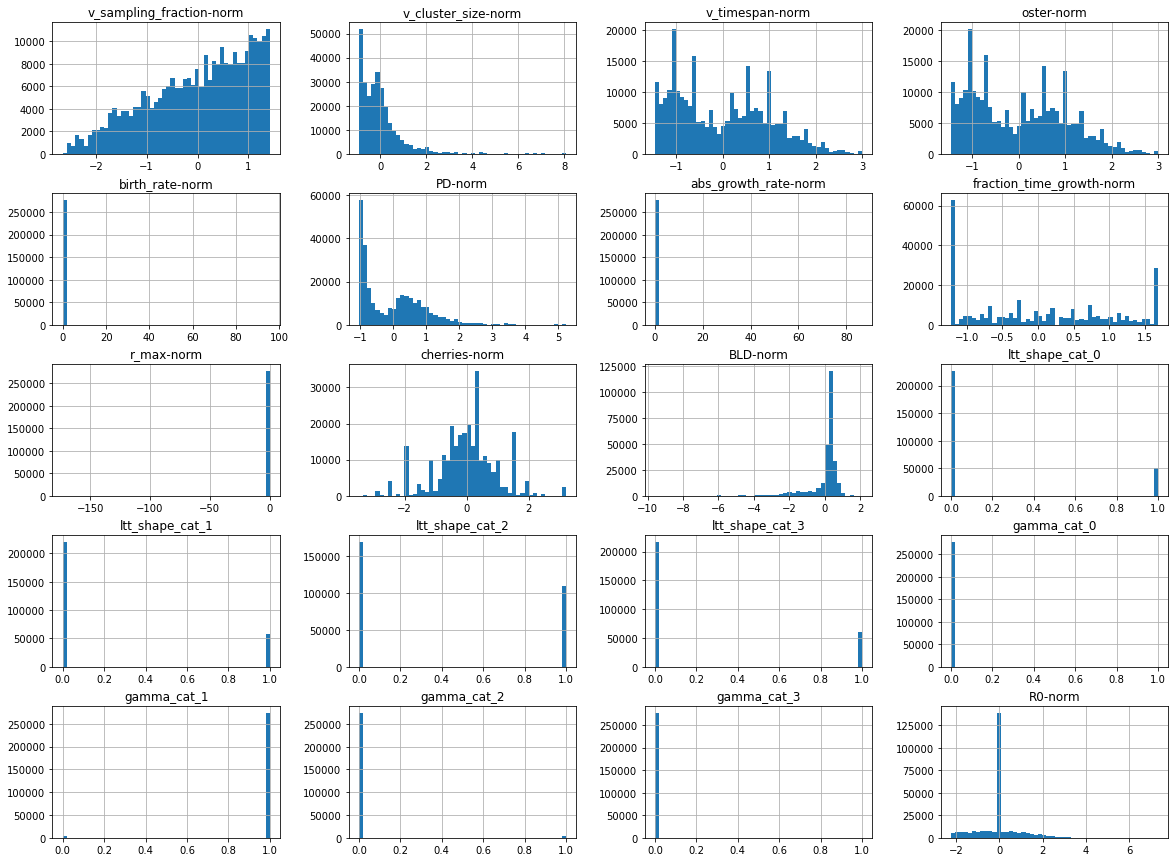

In [14]:
x_train.hist(bins=50,figsize=(20,15))

### Label distribution

Train:
static    82.318550
growth     9.023451
decay      8.657999
Name: dynamic, dtype: float64

Test:
static    82.546047
decay      9.454399
growth     7.999554
Name: dynamic, dtype: float64



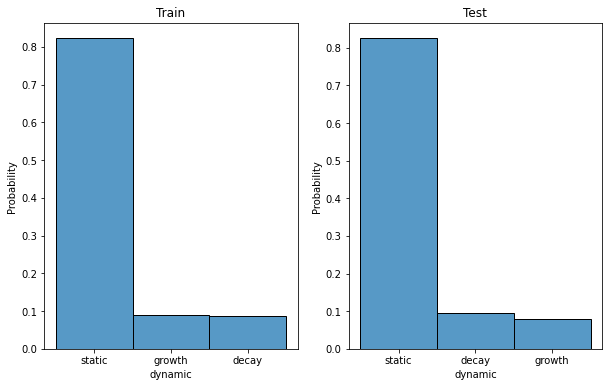

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

for i, (title, label_df) in enumerate(zip(['Train', 'Test'], [train_df['dynamic'], test_df['dynamic']])): 
    sns.histplot(label_df, bins='auto', stat="probability", ax=axs[i])
    axs[i].set_title(title)
    print(f'{title}:\n{label_df.value_counts(normalize=True) * 100}\n')

In [16]:
y_test.head()

0    2
1    2
2    2
3    2
4    2
Name: dynamic_cat, dtype: int64

### SMOTE and RandomOverSampler for resampling the imbalanced data

#### Get the cat features which is used for SMOTENC

In [18]:
import re

col_names = list(x_train.columns)
cat_patterns = ['ltt_shape_cat_\d*', 'gamma_cat_\d']
cat_cols_ids = []

for pattern in cat_patterns:
    for col in col_names:
        m = re.match(pattern, col)
        if m:
            idx = col_names.index(m.group(0))
            cat_cols_ids.append(idx)
            print(col_names[idx])

ltt_shape_cat_0
ltt_shape_cat_1
ltt_shape_cat_2
ltt_shape_cat_3
gamma_cat_0
gamma_cat_1
gamma_cat_2
gamma_cat_3


In [19]:
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from collections import Counter
np.random.seed(0)

train_data_dict = dict()
treeid_col_idx = x_train.shape[1]  # Add the sim col to the end of the trian_df
cat_cols_ids += [treeid_col_idx]

sampler_dict = {
    'org': None,
#     'ros': RandomOverSampler(random_state=0, shrinkage=0.1), 
#     'smotenc': SMOTENC(categorical_features=cat_cols_ids, sampling_strategy='not majority', random_state=0, k_neighbors=5)
}

for sampler_name, sampler in sampler_dict.items():
    if sampler_name == 'org':
        x_train_res, y_train_res = x_train, y_train
        treeid_train = treeid_train
    elif sampler_name in ['ros', 'smotenc']:
        x_train_with_sim = pd.concat([x_train, train_df['sim']], axis=1)
        x_train_with_sim_res, y_train_res = sampler.fit_resample(x_train_with_sim, y_train)
        
        x_train_res = x_train_with_sim_res.iloc[:, :treeid_col_idx]
        treeid_train = x_train_with_sim_res['sim']
    
    train_data_dict[sampler_name] = [x_train_res, y_train_res, treeid_train]
    print(sorted(Counter(y_train_res).items()))

[(0, 24094), (1, 25111), (2, 229081)]


### t-SNE plot

Not saved! The t-SNE feature file has already exited. /data/yanjun/DeepPhyTree/checkpoints/04272021/split_rs123/models_norm_input2/tsne/org/train.npy
   label   t-SNE-1    t-SNE-2
0      2 -8.979057  32.607655
1      2 -8.979057  32.607655
2      2 -8.979057  32.607655
3      2 -8.979057  32.607655
4      2 -8.979057  32.607655
('2', '1', '0')


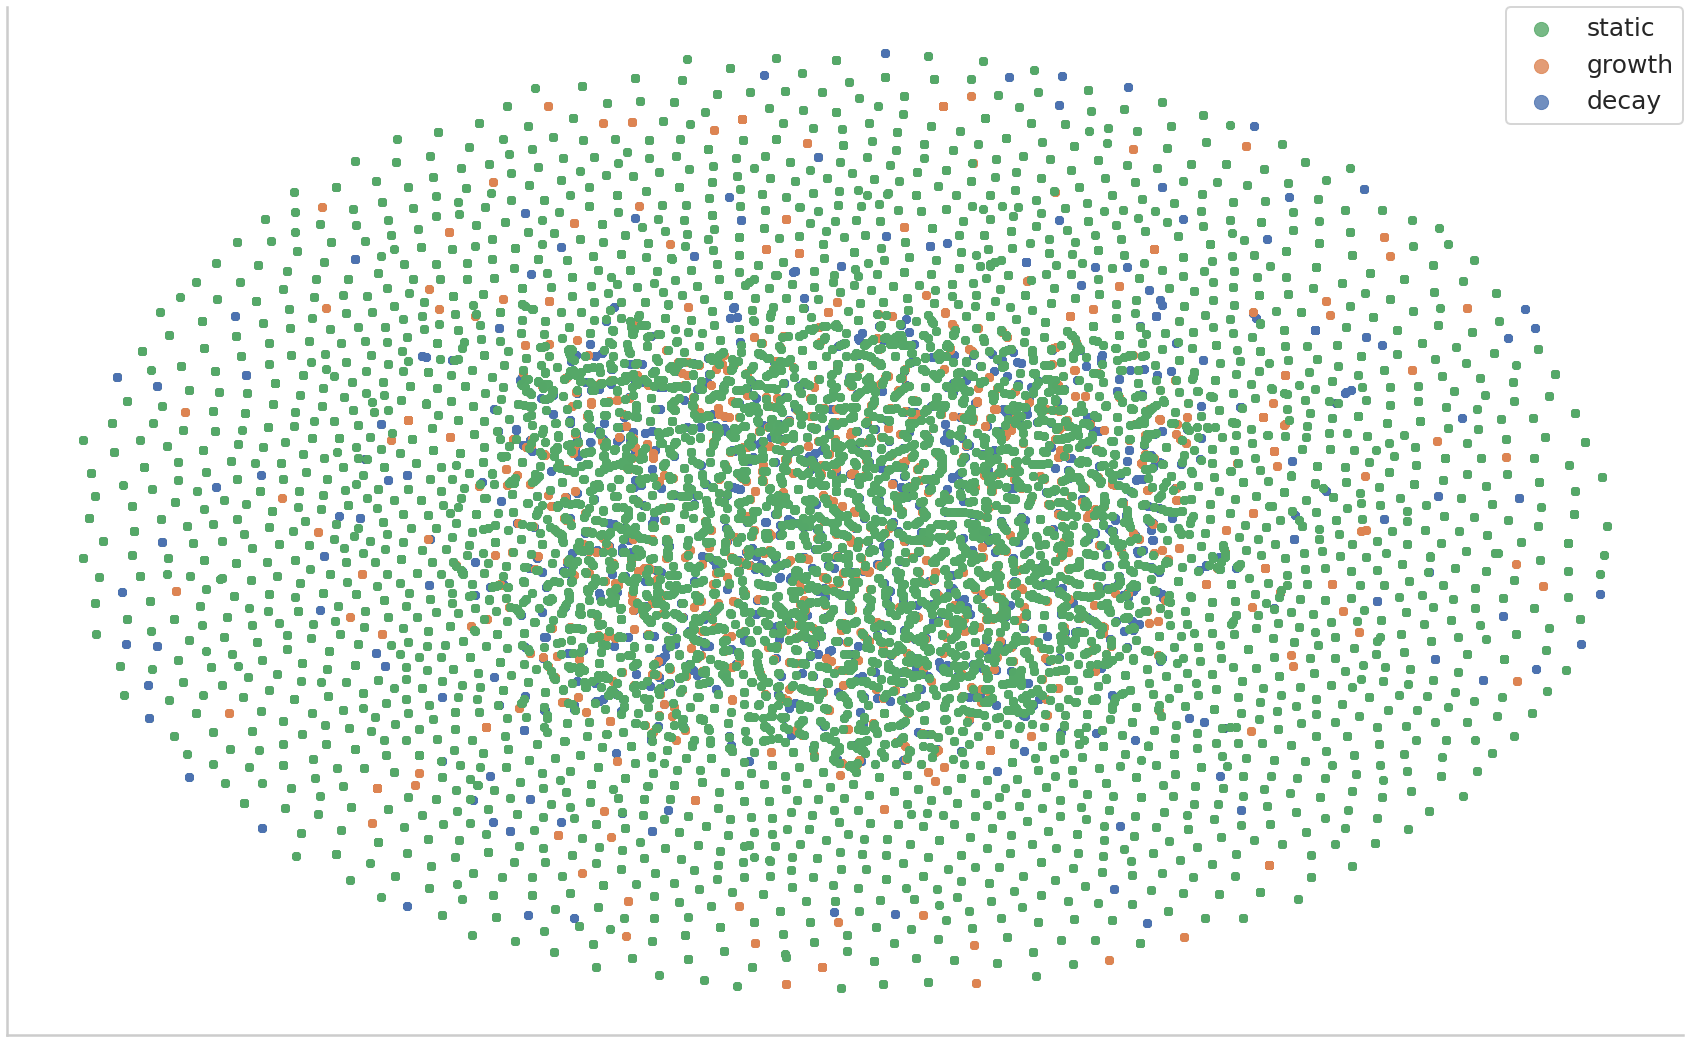

Not saved! The figure /data/yanjun/DeepPhyTree/checkpoints/04272021/split_rs123/models_norm_input2/tsne/org/train.png.png has already existed.


In [20]:
from tsne import AlyTSNE
legend_info = deepcopy(label_map)
tsne_folder = f'/data/yanjun/DeepPhyTree/checkpoints/{ds_name}/split_rs{split_rs}/models_norm_input2/tsne'
os.makedirs(tsne_folder, exist_ok=True)

for sampler_name, (x_train_res, y_train_res, treeid_train) in train_data_dict.items():
    if sampler_name == 'org':
        aly_train_tsne = AlyTSNE(feat=x_train_res.values, label=y_train_res.values, subset='train', save_folder=f'{tsne_folder}/{sampler_name}')
        aly_train_tsne.generate_tsne(overwrite=False)
    else:
        aly_train_tsne = AlyTSNE(feat=x_train_res.values, label=y_train_res.values, subset='train', save_folder=f'{tsne_folder}/{sampler_name}')
        aly_train_tsne.generate_tsne(overwrite=False)
    aly_train_tsne.plot(legend_info=legend_info)

test is done.
   label    t-SNE-1    t-SNE-2
0      2 -39.655594  15.952551
1      2 -39.655594  15.952551
2      2 -39.655594  15.952551
3      2 -39.655594  15.952551
4      2 -39.655594  15.952551
('2', '1', '0')


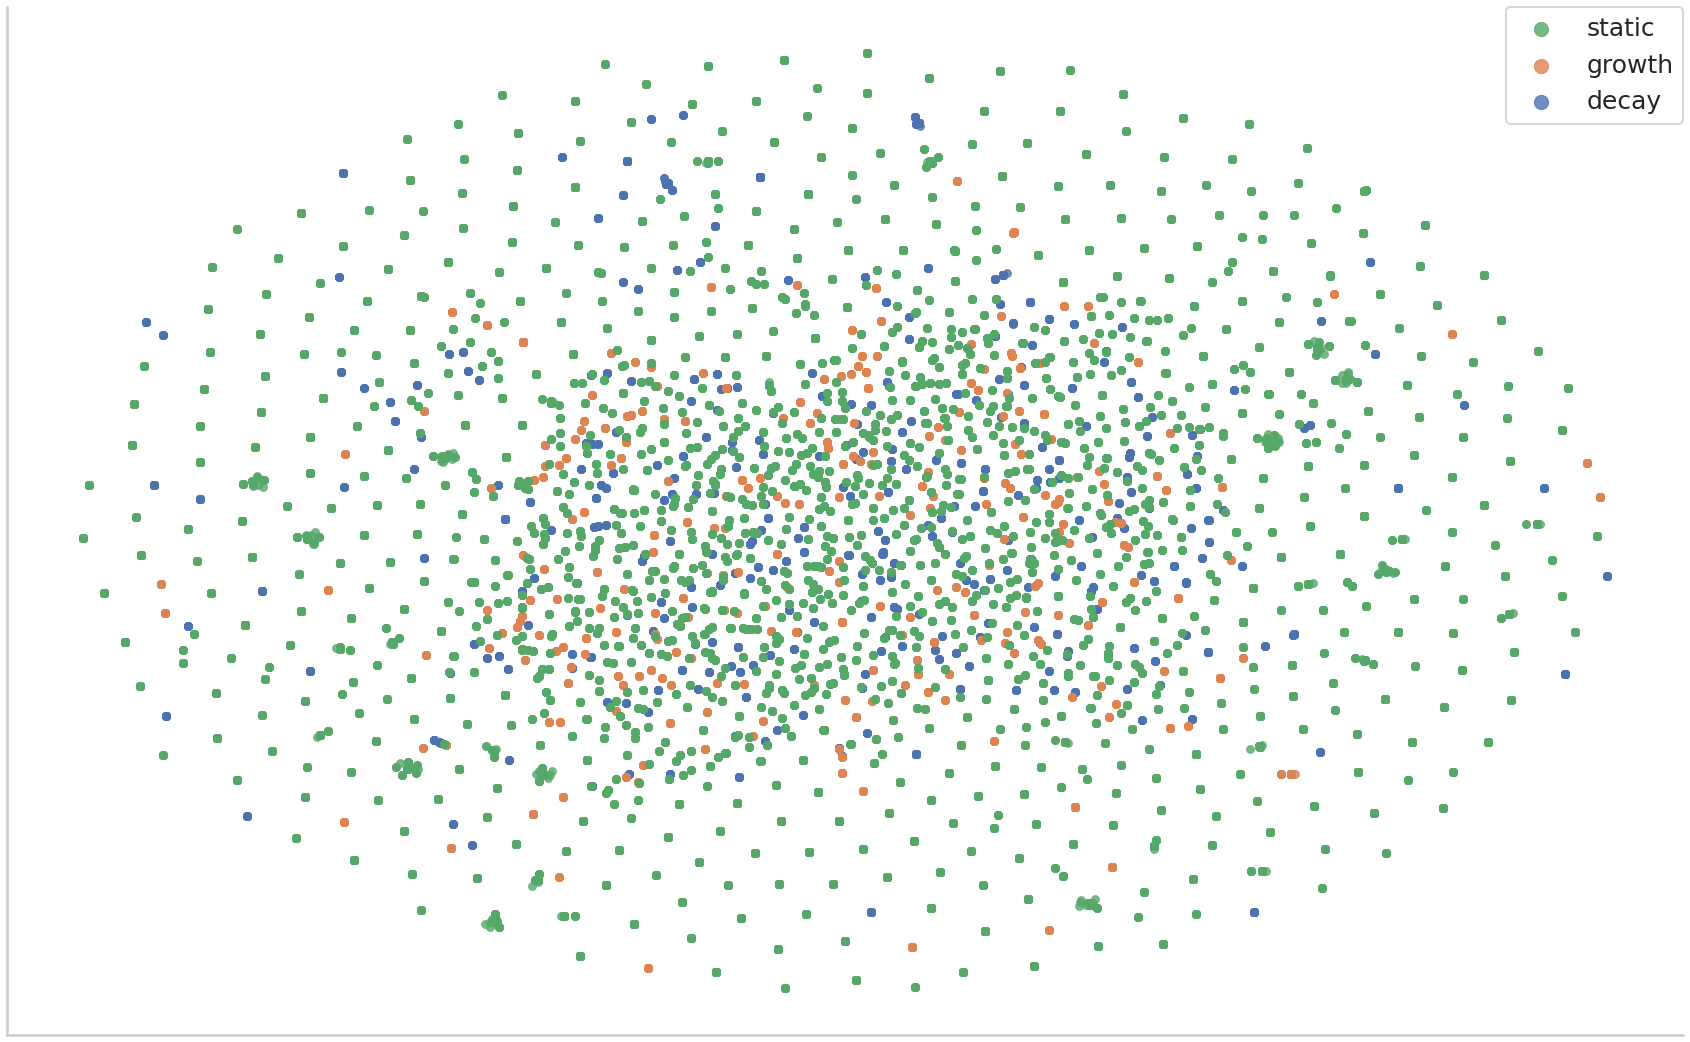

Save the plot /data/yanjun/DeepPhyTree/checkpoints/04272021/split_rs123/models_norm_input2/tsne/org/test.png


In [21]:
aly_test_tsne = AlyTSNE(feat=x_test.values, label=y_test.values, subset='test', save_folder=f'{tsne_folder}/org')
aly_test_tsne.generate_tsne(overwrite=False)
aly_test_tsne.plot(legend_info=legend_info)

### Cross-validation 

In [22]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, GroupKFold
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, balanced_accuracy_score

n_folds = 5
print(f"CV: {n_folds}")

monitor_metric = None # 'f1_weighted'  # balanced_accuracy

# Set a seed for results reproduction
np.random.seed(0)

# Apply cross validation to select the best hyperparameters
# Note: cross validation split should work on the tree id, not node id.
# Incorrect: kf = KFold(n_folds,shuffle=True).split(x)

def cv_train(model, x, y, treeids):
    # TODO: verify the the groups for x
    gkf = GroupKFold(n_splits=5).split(x, groups=treeids)
    cv_val = cross_val_score(model, x, y, scoring=monitor_metric, cv=gkf)
    if not monitor_metric:
        return np.mean(cv_val), 'loss'
    return np.mean(cv_val), monitor_metric

CV: 5


In [23]:
model_folder = f'/data/yanjun/DeepPhyTree/checkpoints/{ds_name}/split_rs{split_rs}/models_norm_input2'
os.makedirs(model_folder, exist_ok=True)

In [24]:
# Onehot the label
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc, roc_auc_score, roc_curve

classes = np.unique(y_train)
n_classes = len(classes)
label_encode_dict = feat_desc['dynamic']

y_test_onehot = label_binarize(y_test, classes=classes)
            
def get_fpr_tpr(n_classes, y_test_onehot, y_test_predscore):    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_test_predscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    # Micro-average: Calculate metrics globally by considering each element of the label indicator matrix as a label.
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_test_predscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc

def plot_roc(n_classes, fpr, tpr, roc_auc):
    fig, axs = plt.subplots(1, 3, figsize=(25, 6))
    lw = 2

    for i, class_id in enumerate(range(n_classes)):
        ax = axs[i]
        ax.plot(fpr[class_id], tpr[class_id], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[class_id])
        ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=25)
        ax.set_ylabel('True Positive Rate', fontsize=25)
        if i != 0:
            ax.set_ylabel('')
        ax.set_title(f'ROC for {label_encode_dict[str(class_id)]}-{class_id}')
        ax.legend(loc="lower right")
    plt.show()    
        
def cal_auc(y_test_onehot, y_test_predscore, metric_dict):
    macro_roc_auc_ovo = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovo",
                                  average="macro")
    # 'weighted': Calculate metrics for each label, and find their average, 
    # weighted by support (the number of true instances for each label).
    weighted_roc_auc_ovo = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovo",
                                         average="weighted") 
    macro_roc_auc_ovr = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovr",
                                      average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovr",
                                         average="weighted")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))
    
    metric_dict['macro_auc_ovo'].append(macro_roc_auc_ovo)
    metric_dict['weighted_auc_ovo'].append(weighted_roc_auc_ovo)
    metric_dict['macro_auc_ovr'].append(macro_roc_auc_ovr)
    metric_dict['weighted_auc_ovr'].append(weighted_roc_auc_ovr)

In [25]:
from numpy import interp
from itertools import cycle

def plot_merged_roc(n_classes, fpr):
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    # Calculate metrics for each label, and find their unweighted mean (by linear interpolation). 
    # This does not take label imbalance into account.
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [26]:
def cal_basic_metric(y_test, y_test_pred, metric_dict):
    acc = accuracy_score(y_test, y_test_pred)
    print(f'Test Acc: {acc}')

    bal_acc = balanced_accuracy_score(y_test, y_test_pred)
    print(f'Test Ballance Acc: {bal_acc}')

    f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
    print(f'Test F1: {f1_weighted}')
    
    metric_dict['acc'].append(acc)
    metric_dict['balance_acc'].append(bal_acc)
    metric_dict['f1_weighted'].append(f1_weighted)

In [27]:
def eval_classifer(model, x_test, y_test, metric_dict):
    y_test_pred = model.predict(x_test)
    y_test_predscore = model.predict_proba(x_test)

    cal_basic_metric(y_test, y_test_pred, metric_dict)
    cal_auc(y_test_onehot, y_test_predscore, metric_dict)
    
    fpr, tpr, roc_auc = get_fpr_tpr(n_classes, y_test_onehot, y_test_predscore)
    plot_roc(n_classes, fpr, tpr, roc_auc)
    

In [28]:
def get_best_classifer(model, cv_func, x_train, y_train, treeid_train, x_test, y_test, metric_dict):
    model.fit(x_train, y_train, cv_func, treeid_train)
    model.best_classifer.fit(x_train, y_train)
    return model.best_classifer

### Softmax regression

===Model for org data===
best validation loss achieved: 0.6094904081953219
Test Acc: 0.5868938729482521
Test Ballance Acc: 0.4975025563119739
Test F1: 0.6603898804006317
One-vs-One ROC AUC scores:
0.740278 (macro),
0.765611 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.740278 (macro),
0.765611 (weighted by prevalence)


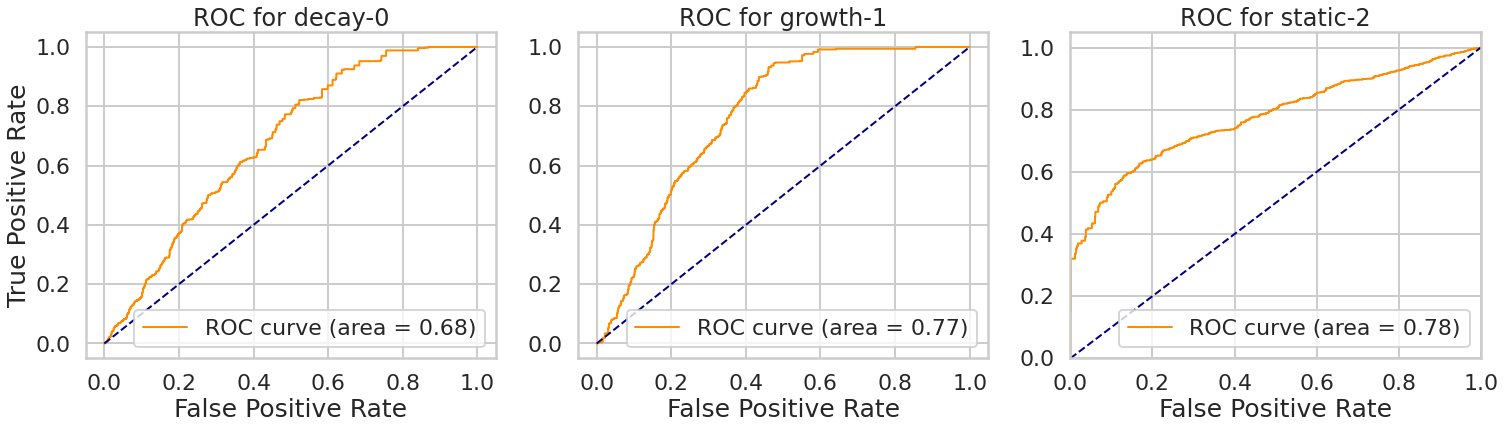

In [29]:
from base_model import Sfmx
from collections import defaultdict

sfmx_model_dict = dict()
sfmx_metric_dict = defaultdict(list)

for sampler_name, (x_train_res, y_train_res, treeid_train) in train_data_dict.items():
    print(f"===Model for {sampler_name} data===")
    
    np.random.seed(0)
    model = Sfmx()
    best_model = get_best_classifer(model, cv_train, x_train_res, y_train_res, treeid_train, 
                                    x_test, y_test, sfmx_metric_dict)
    sfmx_metric_dict['model'].append('softmax')
    sfmx_metric_dict['sampler_name'].append(sampler_name)
    eval_classifer(best_model, x_test, y_test, sfmx_metric_dict)
    sfmx_model_dict[sampler_name] = best_model
    print('\n')

In [30]:
sfmx_metric_df = pd.DataFrame.from_dict(sfmx_metric_dict)
sfmx_metric_df

,model,sampler_name,acc,balance_acc,f1_weighted,macro_auc_ovo,weighted_auc_ovo,macro_auc_ovr,weighted_auc_ovr
0,softmax,org,0.586894,0.497503,0.66039,0.740278,0.765611,0.740278,0.765611


### Coef visualization

In [31]:
def vis_coef(model):
    # print(model.coef_.shape)
    enc_label = list(map(int, sorted(y_test.unique())))
    # print(enc_label)

    coef_df = pd.DataFrame(model.coef_, index=enc_label, columns=input_feat)
    # print(coef_df.head())
    
    coef_ranked_dict = dict()
    fig, axs = plt.subplots(1, 3, figsize=(18, 12))
    for i, label in enumerate(enc_label):
        coef = coef_df.iloc[label]
        
        # Norm the coef
        min_coef, max_coef = min(abs(coef)), max(abs(coef))
        coef = (coef - min_coef) / (max_coef - min_coef)
        
        coef_ranked_dict[label] = sorted(zip(input_feat, coef), key=lambda x: abs(x[1]), reverse=True)
        g = sns.barplot(y=input_feat, x=coef, ax=axs[i])
        if i != 0:
            g.set(yticklabels=[])
    plt.show()
    return coef_ranked_dict

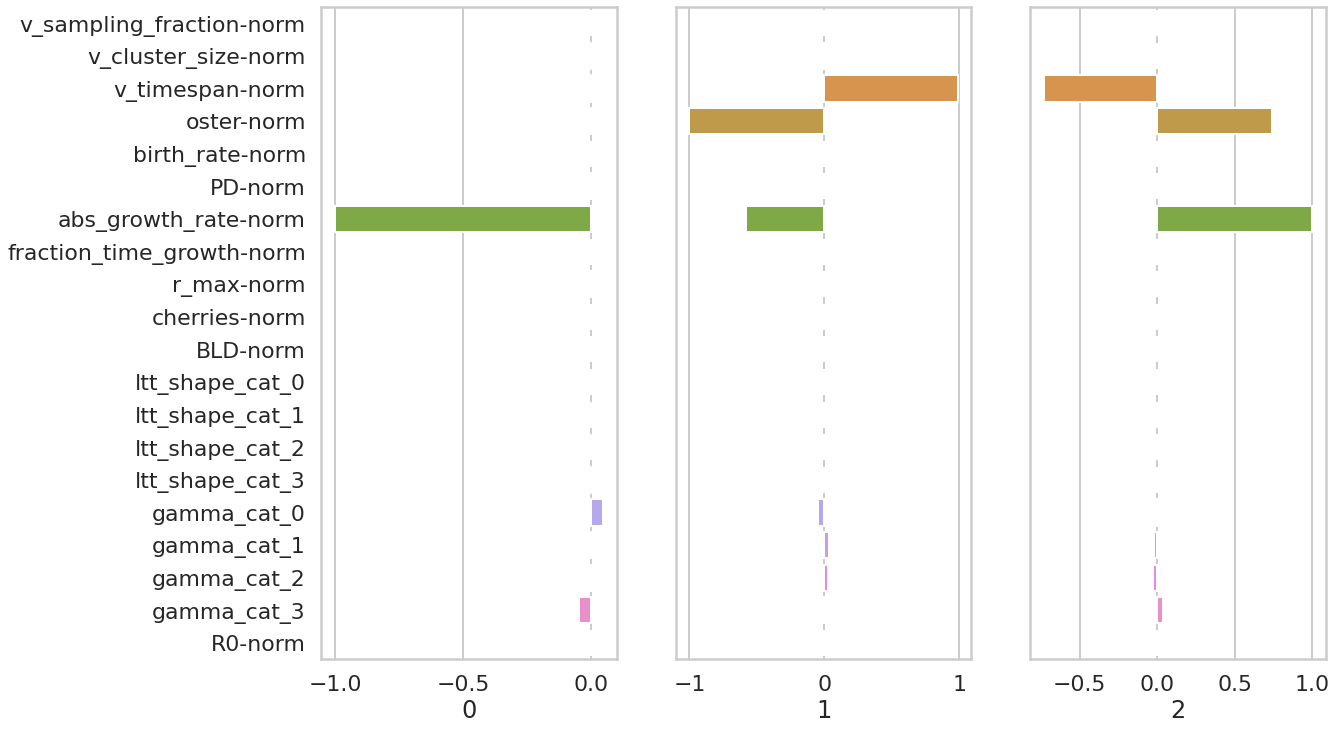

In [32]:
for sampler_type in train_data_dict.keys():
    coef_dict = vis_coef(sfmx_model_dict[sampler_type])

### Save the model 

In [33]:
from joblib import dump, load

def save(model_dict, model_name):
    dump(model_dict, osp.join(model_folder, f'{model_name}.joblib'))

In [34]:
save(sfmx_model_dict, 'sfmx')

### Linear regression with one-vs-rest (OvR) scheme

===Model for org data===
best validation loss achieved: 0.6121768816699495
Test Acc: 0.586142087457712
Test Ballance Acc: 0.4819521811578709
Test F1: 0.660050786772344
One-vs-One ROC AUC scores:
0.745859 (macro),
0.766619 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.745859 (macro),
0.766619 (weighted by prevalence)


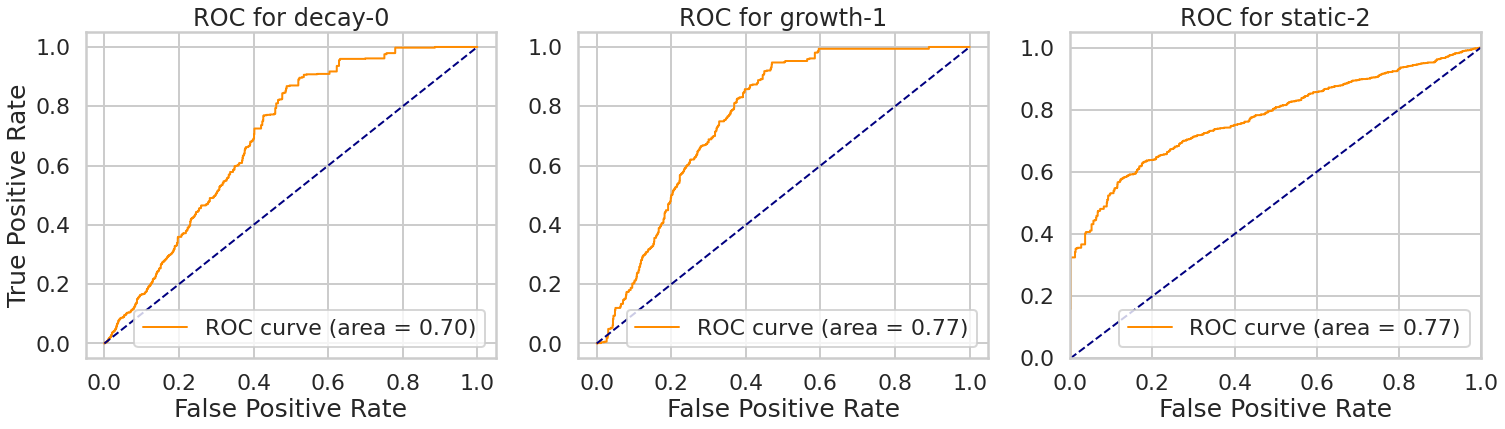

In [35]:
# from base_model import Sfmx

sfmx_ovr_model_dict = dict()
sfmx_ovr_metric_dict = defaultdict(list)

for sampler_name, (x_train_res, y_train_res, treeid_train) in train_data_dict.items():
    print(f"===Model for {sampler_name} data===")
    
    np.random.seed(0)
    model = Sfmx(multi_class='ovr')
    best_model = get_best_classifer(model, cv_train, x_train_res, y_train_res, treeid_train, 
                                    x_test, y_test, sfmx_ovr_metric_dict)
    sfmx_ovr_metric_dict['model'].append('softmax_ovr')
    sfmx_ovr_metric_dict['sampler_name'].append(sampler_name)
    eval_classifer(best_model, x_test, y_test, sfmx_ovr_metric_dict)
    sfmx_ovr_model_dict[sampler_name] = best_model
    print('\n')

In [36]:
sfmx_ovr_metric_df = pd.DataFrame.from_dict(sfmx_metric_dict)
sfmx_ovr_metric_df

,model,sampler_name,acc,balance_acc,f1_weighted,macro_auc_ovo,weighted_auc_ovo,macro_auc_ovr,weighted_auc_ovr
0,softmax,org,0.586894,0.497503,0.66039,0.740278,0.765611,0.740278,0.765611


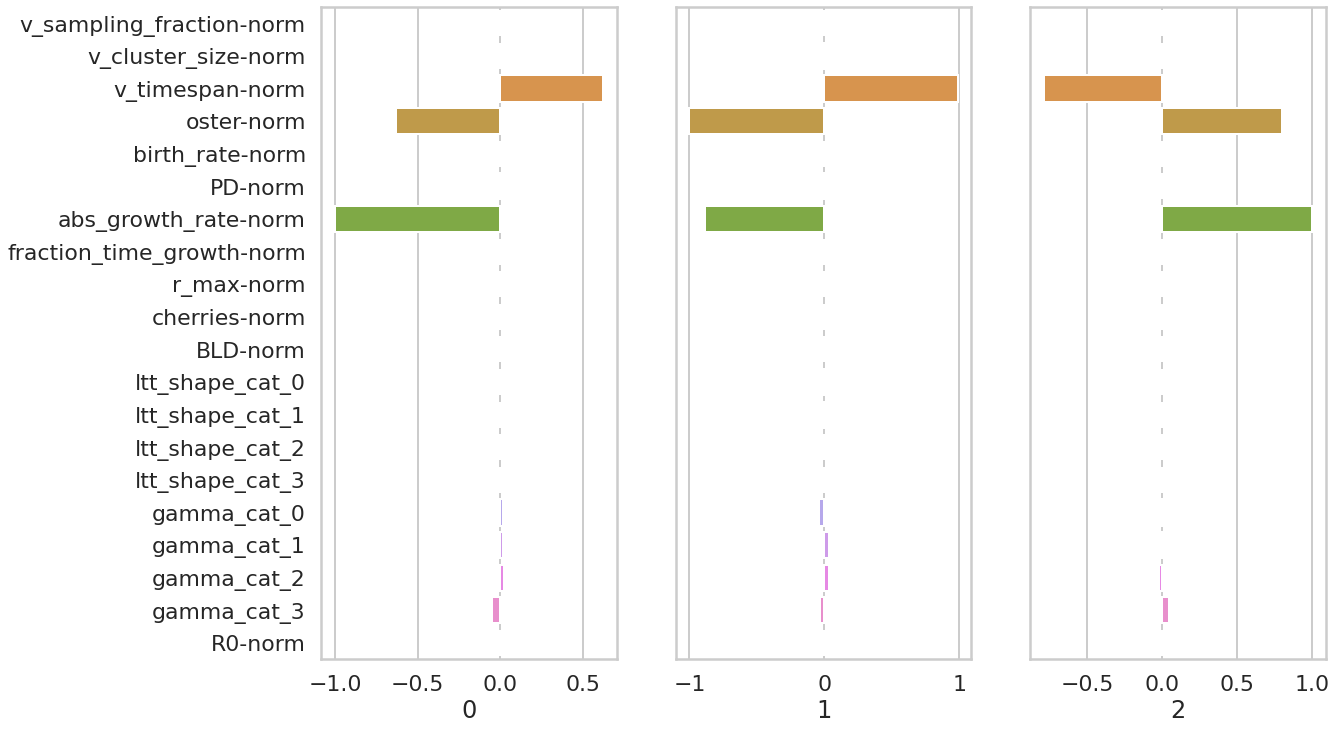

In [37]:
for sampler_type in train_data_dict.keys():
    coef_dict = vis_coef(sfmx_ovr_model_dict[sampler_type])

In [38]:
save(sfmx_model_dict, 'sfmx_ovr')

### Random Forest

===Model for org data===
best validation loss achieved: 0.5801166228240648
Test Acc: 0.5594258586364839
Test Ballance Acc: 0.5322219799031283
Test F1: 0.6353302716588431
One-vs-One ROC AUC scores:
0.754359 (macro),
0.768536 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.754359 (macro),
0.768536 (weighted by prevalence)


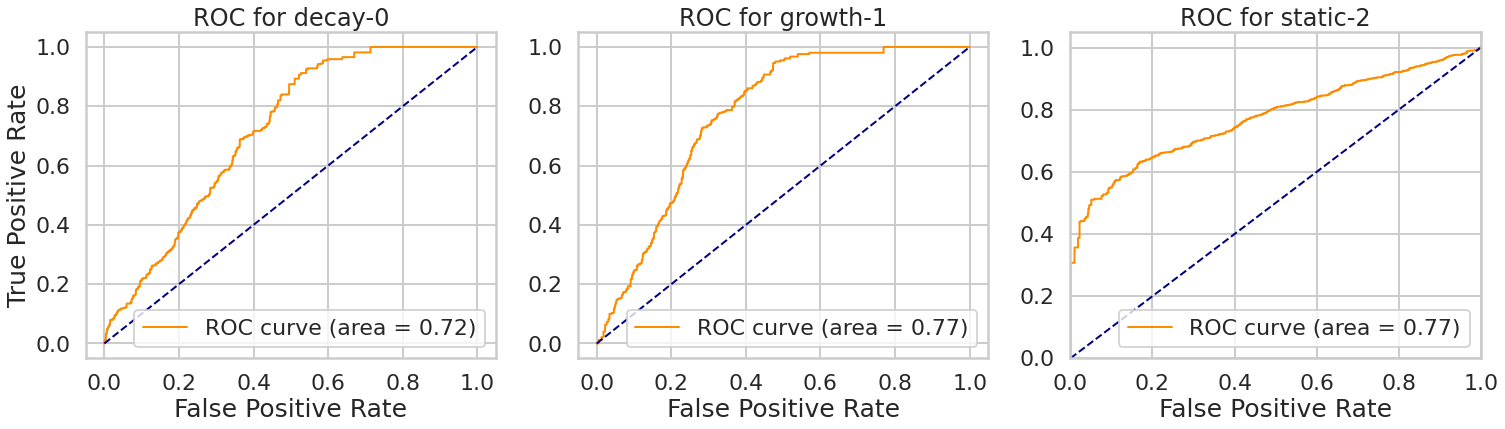

In [39]:
from base_model import RF
from collections import defaultdict

rf_model_dict = dict()
rf_metric_dict = defaultdict(list)

for sampler_name, (x_train_res, y_train_res, treeid_train) in train_data_dict.items():
    np.random.seed(0)
    print(f"===Model for {sampler_name} data===")
    
    model = RF()
    best_model = get_best_classifer(model, cv_train, x_train_res, y_train_res, treeid_train, 
                                    x_test, y_test, sfmx_metric_dict)
    rf_metric_dict['model'].append('rf')
    rf_metric_dict['sampler_name'].append(sampler_name)
    eval_classifer(best_model, x_test, y_test, rf_metric_dict)
    rf_model_dict[sampler_name] = best_model
    print('\n')

### Feature Importance

In [40]:
def cal_feat_impt(model):
    fig, axs = plt.subplots(figsize=(18, 12))

    coef_ranked_dict = dict()

    # Gini importance: The higher, the more important the feature. 
    # The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
    coef = model.feature_importances_

    coef_ranked = sorted(zip(input_feat, coef), key=lambda x: abs(x[1]), reverse=True)
    
    sns.barplot(y=input_feat, x=coef)
    print(coef_ranked)

[('oster-norm', 0.3281046295284721), ('v_timespan-norm', 0.20504252304884205), ('PD-norm', 0.15748255401897157), ('v_cluster_size-norm', 0.1303277665652906), ('r_max-norm', 0.07179952080809916), ('BLD-norm', 0.023783806292572925), ('fraction_time_growth-norm', 0.020104656044413305), ('cherries-norm', 0.016886556217046385), ('v_sampling_fraction-norm', 0.016043901847666294), ('R0-norm', 0.00974045864191848), ('birth_rate-norm', 0.009358580700114888), ('ltt_shape_cat_2', 0.0035724972433874296), ('ltt_shape_cat_1', 0.002457470984227403), ('gamma_cat_2', 0.0018037551396535192), ('gamma_cat_1', 0.0014699571912977652), ('ltt_shape_cat_3', 0.0012379110427186218), ('ltt_shape_cat_0', 0.0006723510087163573), ('abs_growth_rate-norm', 0.00010938355922448369), ('gamma_cat_3', 1.7201173668032119e-06), ('gamma_cat_0', 0.0)]


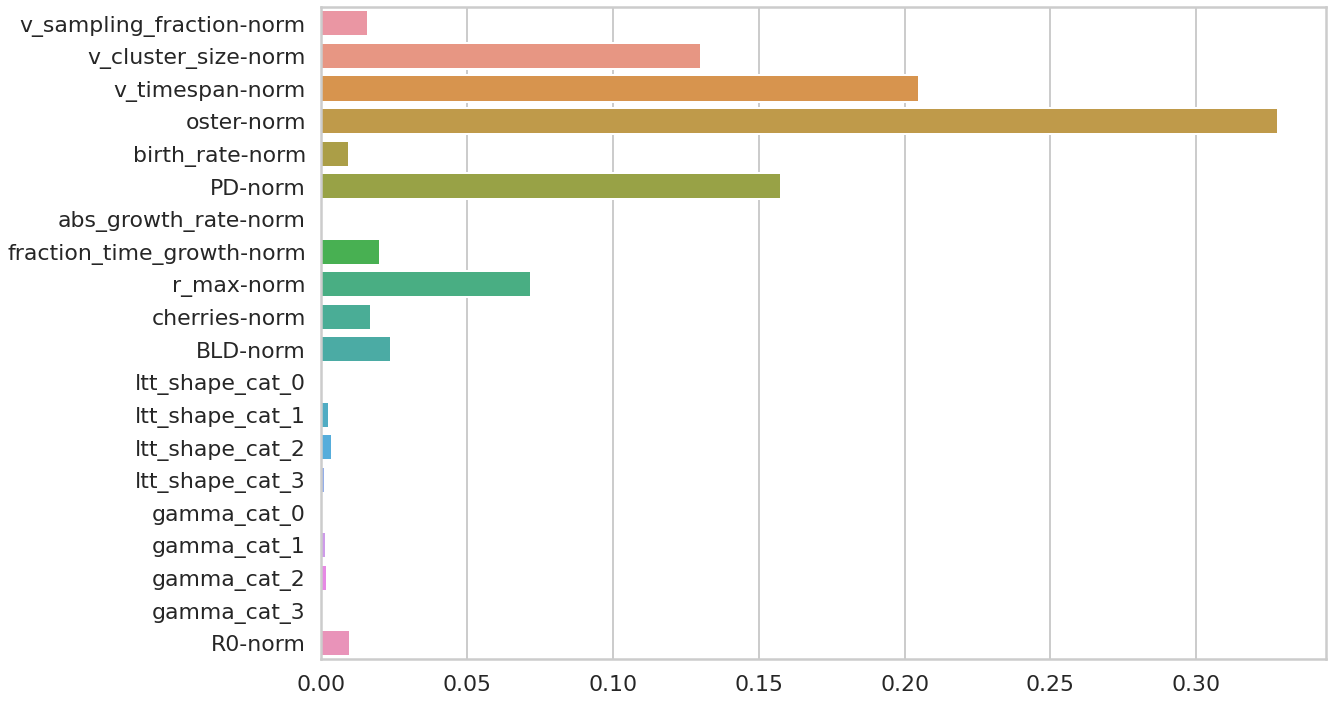

In [41]:
for sampler_type in train_data_dict.keys():
    coef_dict = cal_feat_impt(rf_model_dict[sampler_type])

In [42]:
save(rf_model_dict, 'rf')

### Analyze the mis-classcification 

In [43]:
def get_misclass(y_true, y_pred):
    mis_id_dict = defaultdict(dict)
    mis_ids = y_true != y_pred
    print(f'Total Mis: {sum(mis_ids)}, ({100 * sum(mis_ids) / len(y_true):.3f}%)')
    
    print(label_map)
    for i in range(len(label_map)):
        label_ids = y_true == i
        sub_mis_id_dict = defaultdict(list)
        
        for idx, (label_id, mis_id) in enumerate(zip(label_ids, mis_ids)):
            if label_id and mis_id:
                sub_mis_id_dict[y_pred[idx]].append(idx)
        
        n_mis = sum([len(mis_lst) for mis_lst in sub_mis_id_dict.values()])
        n_sample = sum(label_ids)
        
        print(f'Mis-classified of {label_map[i]}: {n_mis}/{n_sample}, ({100 * n_mis / n_sample:.3f}%)')
        for mis_label, mis_lst in sub_mis_id_dict.items():
            print(f'\t{mis_label}: {len(mis_lst)}')
        
        mis_id_dict[i] = sub_mis_id_dict
    return mis_id_dict

In [44]:
rf_model = rf_model_dict['org']
y_test_pred = rf_model.predict(x_test)
y_test_predscore = rf_model.predict_proba(x_test)
y_test_arr = y_test.values

mis_id_dict = get_misclass(y_test_arr, y_test_pred)

Total Mis: 31646, (44.057%)
{0: 'decay', 1: 'growth', 2: 'static'}
Mis-classified of decay: 4848/6791, (71.389%)
	1: 3814
	2: 1034
Mis-classified of growth: 1511/5746, (26.297%)
	0: 1252
	2: 259
Mis-classified of static: 25287/59292, (42.648%)
	0: 9191
	1: 16096


In [45]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_arr, y_test_pred)
conf_mat

array([[ 1943,  3814,  1034],
       [ 1252,  4235,   259],
       [ 9191, 16096, 34005]])

In [46]:
list(label_map.values())

['decay', 'growth', 'static']

[None, None, None, None, None, None]

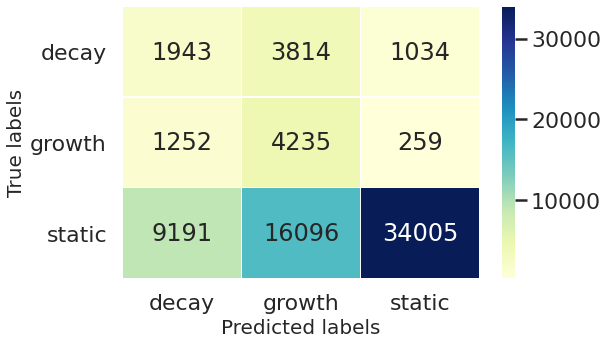

In [47]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", linewidths=.5, cmap="YlGnBu", ax=ax)
ax.set_ylabel('True labels', fontsize=20)
ax.set_xlabel('Predicted labels', fontsize=20)

ax.set_xticklabels(list(label_map.values()))
ax.set_yticklabels(list(label_map.values()))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

In [48]:
# Merget the test data and prediction
y_test_true_df = pd.DataFrame({'true': y_test})
y_test_pred_df = pd.DataFrame({'pred': y_test_pred})
test_pred_df = pd.concat([x_test, y_test_true_df, y_test_pred_df], axis=1)
test_pred_df.to_csv(osp.join(model_folder, 'rf_org_pred.csv'), index=False)

test_pred_df.tail()

,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,...,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,R0-norm,true,pred
71824,-1.20778,-0.76702,-0.584765,-0.585766,-0.024907,-0.705023,-0.012074,-1.219814,0.014845,0.338662,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.040925,1,0
71825,-1.20778,-0.76702,-0.584765,-0.585766,-0.024907,-0.705023,-0.012074,-1.219814,0.014845,0.338662,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.040925,1,0
71826,-1.20778,-0.76702,-0.584765,-0.585766,-0.024907,-0.705023,-0.012074,-1.219814,0.014845,0.338662,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.040925,1,0
71827,-1.20778,-0.76702,-0.584765,-0.585766,-0.024907,-0.705023,-0.012074,-1.219814,0.014845,0.338662,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.040925,1,0
71828,-1.20778,-0.76702,-0.584765,-0.585766,-0.024907,-0.705023,-0.012074,-1.219814,0.014845,0.338662,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.040925,1,0


In [49]:
legend_info

{0: 'decay', 1: 'growth', 2: 'static'}

In [50]:
pred_label_map = deepcopy(label_map)
extend_legend_info = deepcopy(legend_info)

rvs_pred_label_map = defaultdict(dict)
new_label = len(label_map)

for label in range(n_classes):
    for mis_pred in range(n_classes):
        if label != mis_pred:
            rvs_pred_label_map[label][mis_pred] = new_label
            pred_label_map[new_label] = {'true': label, 'pred': mis_pred}
            extend_legend_info[new_label] = f'{label_map[label]}->{label_map[mis_pred]}'
            new_label += 1
pred_label_map

{0: 'decay',
 1: 'growth',
 2: 'static',
 3: {'true': 0, 'pred': 1},
 4: {'true': 0, 'pred': 2},
 5: {'true': 1, 'pred': 0},
 6: {'true': 1, 'pred': 2},
 7: {'true': 2, 'pred': 0},
 8: {'true': 2, 'pred': 1}}

In [51]:
extend_legend_info

{0: 'decay',
 1: 'growth',
 2: 'static',
 3: 'decay->growth',
 4: 'decay->static',
 5: 'growth->decay',
 6: 'growth->static',
 7: 'static->decay',
 8: 'static->growth'}

In [52]:
extend_y_test_pred = []

for y_true, y_pred in zip(y_test, y_test_pred):
    if y_true == y_pred:
        extend_y_test_pred.append(y_true)
    else:
        extend_label = rvs_pred_label_map[y_true][y_pred]
        extend_y_test_pred.append(extend_label)
print(extend_y_test_pred[-10:])

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


test_pred is done.
   label    t-SNE-1    t-SNE-2
0      2 -39.655594  15.952551
1      2 -39.655594  15.952551
2      2 -39.655594  15.952551
3      2 -39.655594  15.952551
4      2 -39.655594  15.952551
('8', '7', '6', '5', '4', '3', '2', '1', '0')


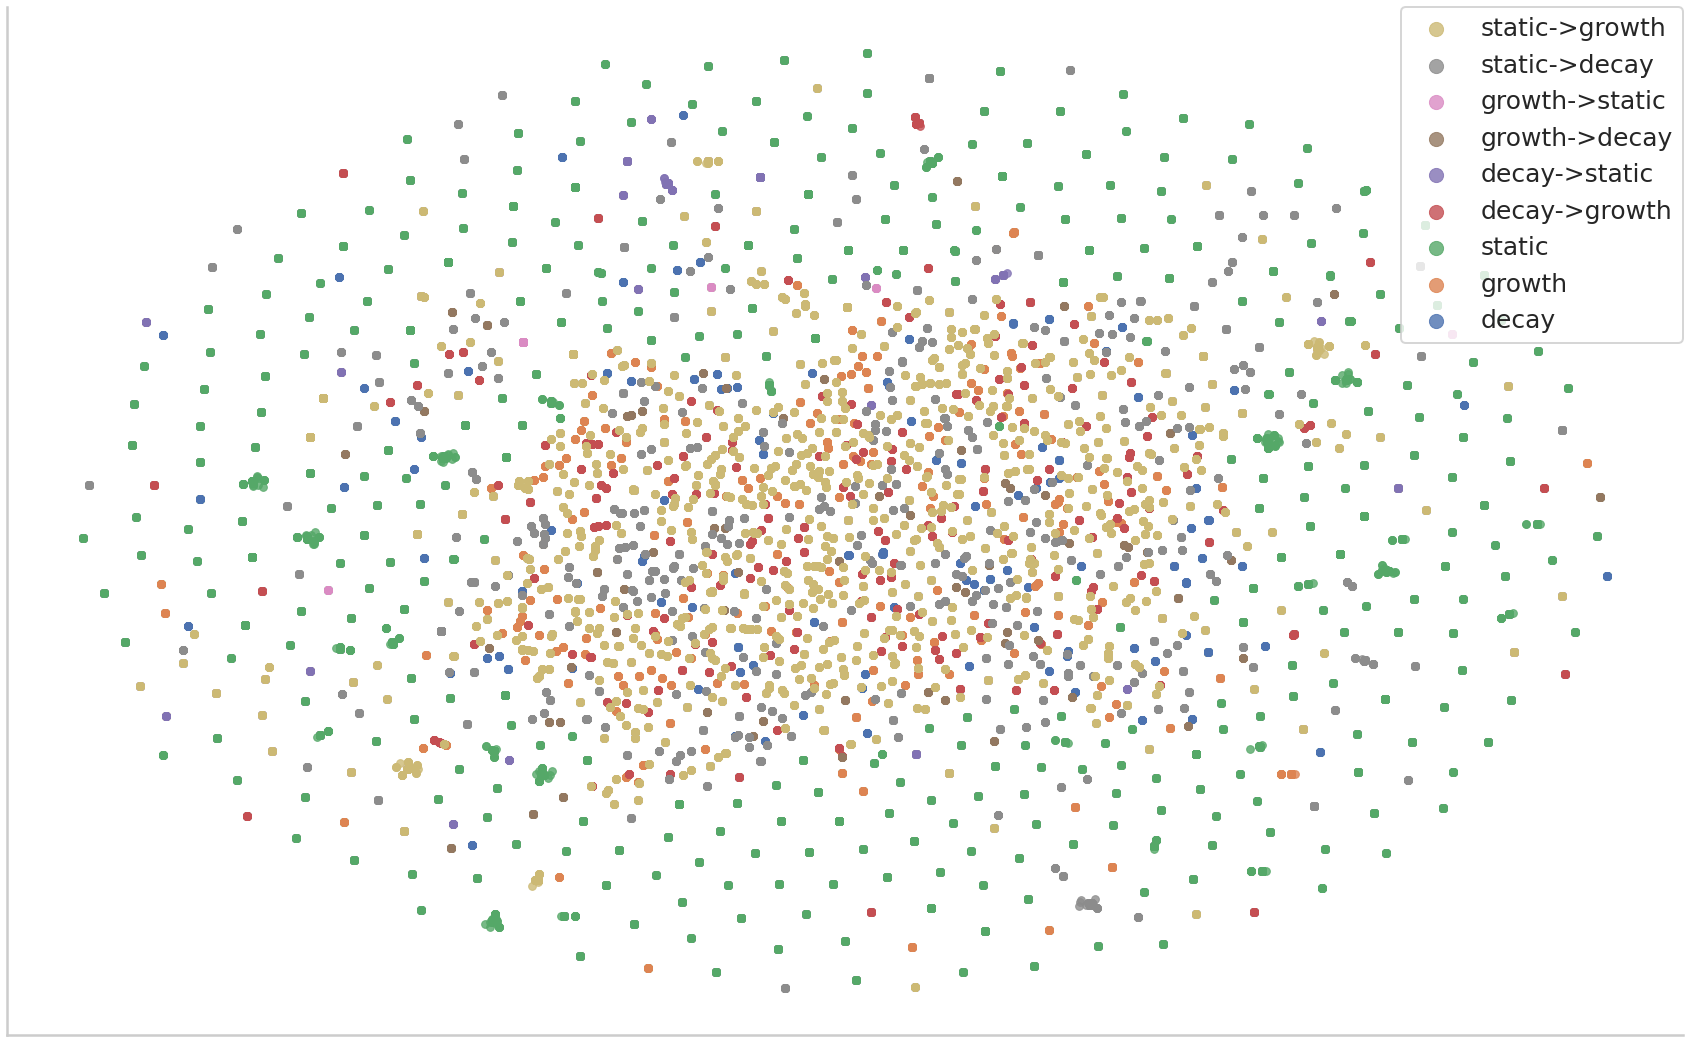

Save the plot /data/yanjun/DeepPhyTree/checkpoints/04272021/split_rs123/models_norm_input2/tsne/org/test_pred.png


In [53]:
aly_test_tsne = AlyTSNE(feat=x_test.values, label=extend_y_test_pred, subset='test_pred', save_folder=f'{tsne_folder}/org')
aly_test_tsne.generate_tsne(overwrite=False)
aly_test_tsne.plot(legend_info=extend_legend_info)

### XGBoost

===Model for org data===
best validation loss achieved: 0.8098575237607257
Test Acc: 0.8047306798089908
Test Ballance Acc: 0.3396385387899021
Test F1: 0.7440419622313441
One-vs-One ROC AUC scores:
0.771667 (macro),
0.773961 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.771667 (macro),
0.773961 (weighted by prevalence)


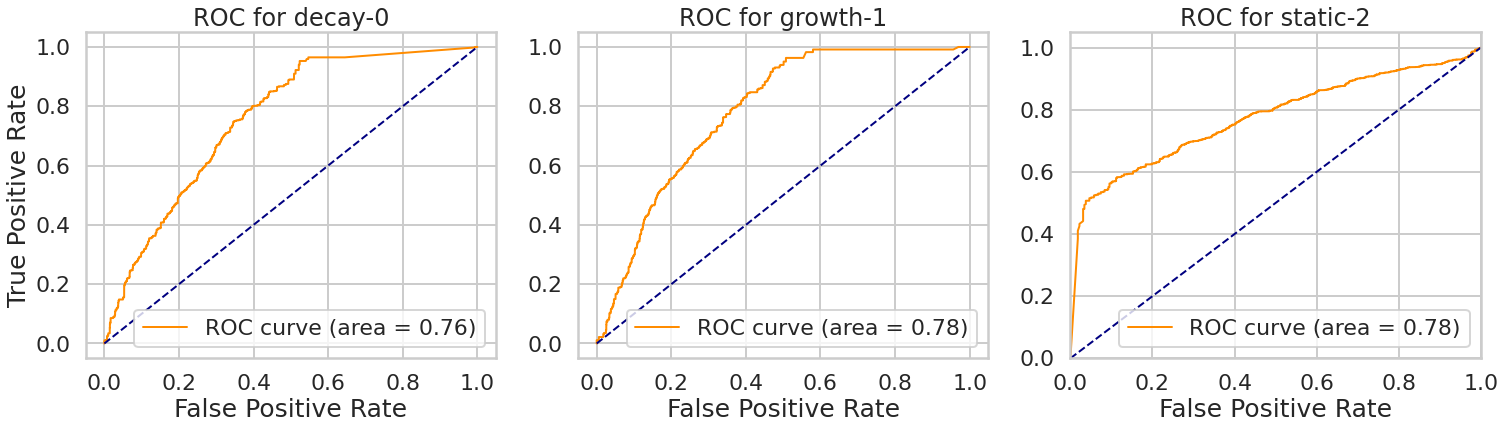

In [54]:
from base_model import XGB

xgb_model_dict = dict()
xgb_metric_dict = defaultdict(list)

for sampler_name, (x_train_res, y_train_res, treeid_train) in train_data_dict.items():
    np.random.seed(0)
    print(f"===Model for {sampler_name} data===")
    
    model = XGB()
    best_model = get_best_classifer(model, cv_train, x_train_res, y_train_res, treeid_train, 
                                    x_test, y_test, sfmx_metric_dict)
    xgb_metric_dict['model'].append('rf')
    xgb_metric_dict['sampler_name'].append(sampler_name)
    eval_classifer(best_model, x_test, y_test, xgb_metric_dict)
    xgb_model_dict[sampler_name] = best_model
    print('\n')

[('oster-norm', 0.15087532), ('v_timespan-norm', 0.09161161), ('gamma_cat_2', 0.06256623), ('v_cluster_size-norm', 0.057002112), ('ltt_shape_cat_3', 0.05477935), ('PD-norm', 0.05171974), ('fraction_time_growth-norm', 0.0496885), ('ltt_shape_cat_0', 0.04888124), ('ltt_shape_cat_1', 0.046214424), ('birth_rate-norm', 0.045960724), ('r_max-norm', 0.044969223), ('ltt_shape_cat_2', 0.044452272), ('gamma_cat_1', 0.043260075), ('R0-norm', 0.042657807), ('BLD-norm', 0.04024505), ('v_sampling_fraction-norm', 0.040206946), ('cherries-norm', 0.038159426), ('gamma_cat_0', 0.024921387), ('abs_growth_rate-norm', 0.02182846), ('gamma_cat_3', 0.0)]


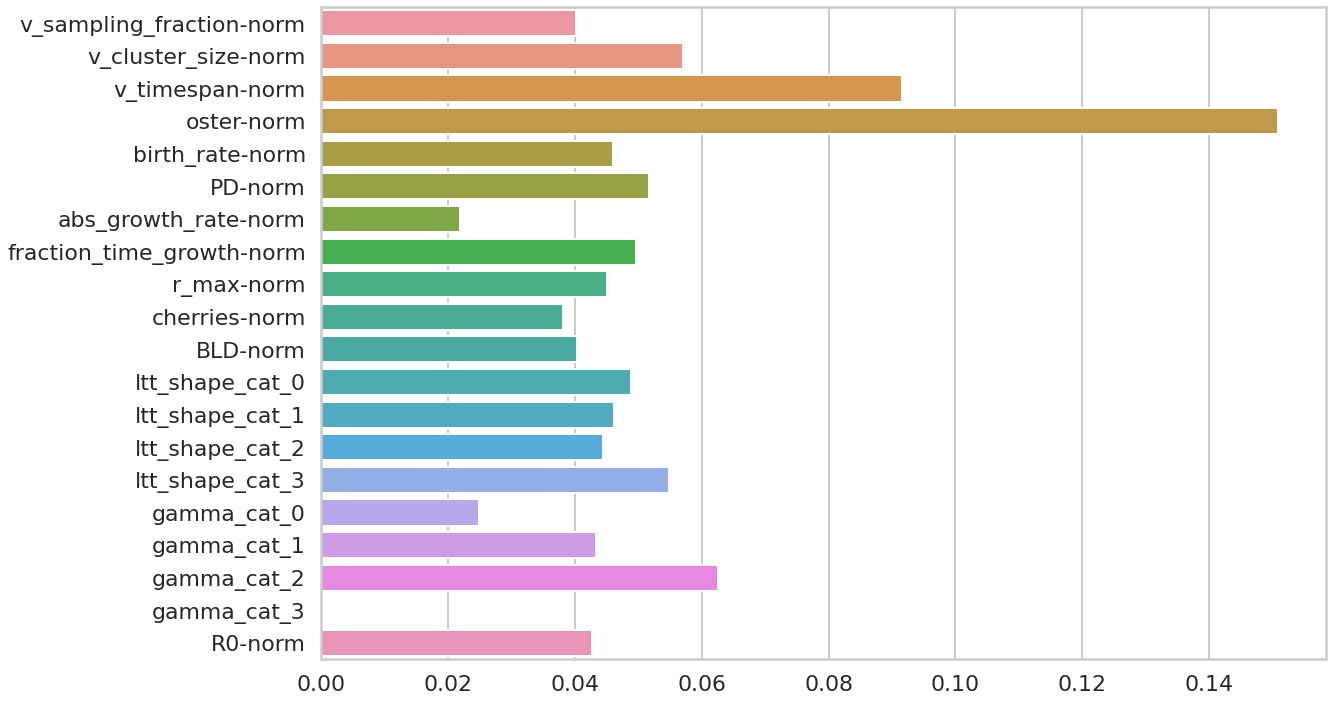

In [55]:
for sampler_type in train_data_dict.keys():
    coef_dict = cal_feat_impt(xgb_model_dict[sampler_type])

In [56]:
from xgboost import plot_importance, plot_tree

def plot_impt(model):
    fig, axs = plt.subplots(2, 1, figsize=(10, 20))

    # Feature importance type: 
    # "gain" is the average gain of splits which use the feature
    # "weight" is the number of times a feature appears in a tree

    for i, impt_type in enumerate(['gain', 'weight']): 
        ax = plot_importance(model, importance_type=impt_type, ax=axs[i], show_values=False)
        ax.set_title(f'Feature importance: {impt_type}')
    plt.show()

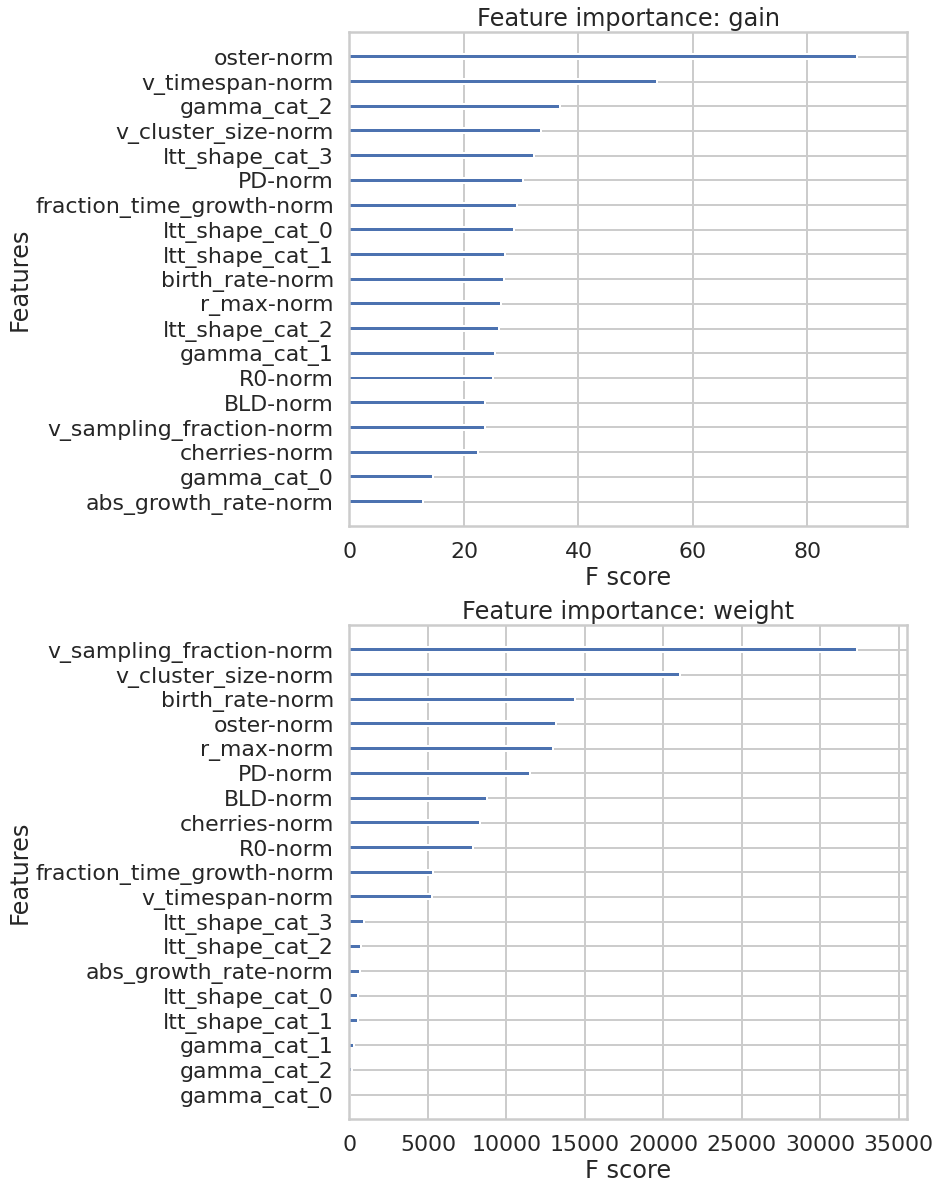

In [57]:
for sampler_type in train_data_dict.keys():
    plot_impt(xgb_model_dict[sampler_type])
    break

In [58]:
save(xgb_metric_dict, 'xgb')